In [2]:
import os
import boto3
import json
import re
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import (split, array)
from pandas import read_csv
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import (LSTM, Dense, Flatten, RepeatVector, TimeDistributed, )
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [3]:
# define client, folder and files for AWS.
s3_client = boto3.client("s3")
s3_bucket_name = 'thesis-hydroponic-project'
s3_bucket_prefix = 'TemperatureAndHumidity2021/'

In [4]:
# Fetch existing data or load fresh data.
# Remove redundancy and null.
files = s3_client.list_objects(Bucket=s3_bucket_name, Prefix=s3_bucket_prefix)['Contents']
parsed_sensor_values = []
for file in files:
    if not os.path.isfile('.cache/' + file['Key']) or (datetime.now() - datetime.fromtimestamp(os.path.getctime('.cache/' + file['Key']))).days > 31:
        print("Fetching fresh file from S3:", file['Key'])
        s3_object = s3_client.get_object(Bucket=s3_bucket_name, Key= file['Key'])
        raw_sensor_values = s3_object['Body'].read().decode()
        clean_sensor_values = re.sub(",+", ",", raw_sensor_values)
        sensor_values = json.loads("[" + clean_sensor_values.strip(',') + "]")
    else:
        print("Load from cache:", file['Key'])
        with open('.cache/' + file['Key']) as f:
            sensor_values = json.load(f)
    parsed_sensor_values += sensor_values
    os.makedirs('.cache/' + os.path.dirname(file['Key']), exist_ok=True)
    with open('.cache/' + file['Key'], 'w') as f:
        json.dump(sensor_values, f)

6c6fb18-9e1a-43be-b757-be56c2653c5b
Fetching fresh file from S3: TemperatureAndHumidity2021/03/07/13/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-13-06-04-7942ff14-8955-4210-993c-016919bc4541
Fetching fresh file from S3: TemperatureAndHumidity2021/03/07/13/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-13-21-07-26a8a1a1-b350-4148-9d09-8f26c12faba1
Fetching fresh file from S3: TemperatureAndHumidity2021/03/07/13/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-13-36-15-e37c0c3b-8b66-4cfa-a153-9ca613ad1620
Fetching fresh file from S3: TemperatureAndHumidity2021/03/07/13/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-13-51-22-8770a1b4-fd95-4a6a-b356-74e8969cdff7
Fetching fresh file from S3: TemperatureAndHumidity2021/03/07/14/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-14-06-24-f5e6c64f-916f-4f72-952d-cfe0e1a4cdaa
Fetching fresh file from S3: TemperatureAndHumidity2021/03/07/14/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-14-21-28-3fb19ddb-75ce-4f0a-a5cd-ffb46b33d1c

## Data preparation

In [5]:
df = pd.DataFrame(parsed_sensor_values)
df['temperature'] = df['temperature'].astype(float)
df['humidity'] = df['humidity'].astype(float)
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', ascending=True, inplace=True)

In [6]:
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (16059, 4)


,sensor_type,temperature,humidity,datetime
0,hydroponic sensor,14.0,38.0,2021-02-26 08:51:37
1,hydroponic sensor,15.0,36.0,2021-02-26 08:51:43
2,hydroponic sensor,15.0,36.0,2021-02-26 08:51:48
3,hydroponic sensor,15.0,36.0,2021-02-26 08:51:53
4,hydroponic sensor,15.0,35.0,2021-02-26 08:51:58


In [7]:
# resample data to hourly
hourly_groups = df.set_index('datetime').resample('1H')
# Calulating the mean will simply eliminate the data outliers
hourly_data = hourly_groups.mean()
# summarize
print(hourly_data.shape)
print(hourly_data)
# save
hourly_data.to_csv('temperature_humidity_hourly.csv')

(254, 2)
                     temperature   humidity
datetime                                   
2021-02-26 08:00:00    20.978495  27.376344
2021-02-26 09:00:00    23.768421  24.040602
2021-02-26 10:00:00    25.008850  30.794690
2021-02-26 11:00:00    22.839286  31.142857
2021-02-26 12:00:00    23.854545  29.054545
...                          ...        ...
2021-03-08 17:00:00    24.000000  16.000000
2021-03-08 18:00:00    24.000000  15.525424
2021-03-08 19:00:00    24.000000  16.000000
2021-03-08 20:00:00    24.000000  15.644068
2021-03-08 21:00:00    24.000000  15.000000

[254 rows x 2 columns]


In [9]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    temp_a = int((len(data)*0.8)/7)
    split_index = temp_a*7
    temp_b = int(len(data)/7)
    end_index = temp_b*7
    # split into standard weeks(i.e. divisible by 7)
    train, test = data[:split_index], data[split_index:end_index]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [10]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [11]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [12]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [13]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [14]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [15]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [16]:
# load the new file
dataset = read_csv('temperature_humidity_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)

lstm: [1.232] 1.1, 1.2, 1.3, 1.3, 1.2, 1.3, 1.3


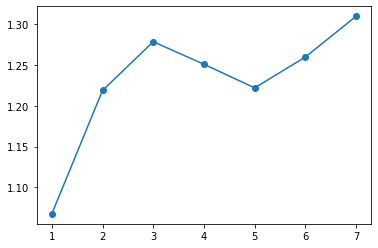

In [18]:
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
hrs = ['1', '2', '3', '4', '5', '6', '7']
pyplot.plot(hrs, scores, marker='o', label='lstm')
pyplot.show()